In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D,
    MaxPooling1D,
    LSTM,
    Bidirectional,
    Dropout,
    Flatten,
    Dense,
    Input,
)
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

from utils import load_dataset, train, plot_roc, auc
from datetime import datetime
from einops import rearrange

%load_ext tensorboard

In [2]:
X_train, y_train, X_test, y_test = load_dataset("FOX_0.50")

FOX_0.50.tar.gz: 82.3MB [00:00, 87.9MB/s]                  
Extracted tarball


In [6]:
model = Sequential(
    [
        Input((1000, 4)),
        Conv1D(200, kernel_size=26, activation="relu"),
        MaxPooling1D(pool_size=13, strides=13),
        Dropout(0.2),
        Bidirectional(LSTM(200, return_sequences=True)),
        Dropout(0.5),
        Flatten(),
        Dense(1024, activation="relu"),
        Dense(9, activation="sigmoid"),
    ],
    name="conv-lstm",
)

es = EarlyStopping(monitor="val_loss", patience=5)
optimizer = Adam(lr=1e-3)
tensorboard_callback = TensorBoard(log_dir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[AUC(multi_label=True), "acc"],
)

In [7]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.math import exp

def scheduler(epoch, lr):
    if epoch < 10:
        return lr

    return lr * exp(-0.1)

lr_schedule = LearningRateScheduler(scheduler)

Epoch 1/60
1700/1700 - 72s - loss: 0.3535 - auc: 0.6994 - acc: 0.2985 - val_loss: 0.3261 - val_auc: 0.7796 - val_acc: 0.3561
Epoch 2/60
1700/1700 - 67s - loss: 0.3195 - auc: 0.7813 - acc: 0.3789 - val_loss: 0.3169 - val_auc: 0.8115 - val_acc: 0.3997
Epoch 3/60
1700/1700 - 69s - loss: 0.3060 - auc: 0.8122 - acc: 0.4088 - val_loss: 0.2972 - val_auc: 0.8336 - val_acc: 0.4253
Epoch 4/60
1700/1700 - 69s - loss: 0.2953 - auc: 0.8318 - acc: 0.4338 - val_loss: 0.2909 - val_auc: 0.8429 - val_acc: 0.4268
Epoch 5/60
1700/1700 - 70s - loss: 0.2867 - auc: 0.8456 - acc: 0.4517 - val_loss: 0.2868 - val_auc: 0.8526 - val_acc: 0.4391
Epoch 6/60
1700/1700 - 70s - loss: 0.2795 - auc: 0.8575 - acc: 0.4659 - val_loss: 0.2868 - val_auc: 0.8538 - val_acc: 0.4337
Epoch 7/60
1700/1700 - 69s - loss: 0.2716 - auc: 0.8708 - acc: 0.4828 - val_loss: 0.2834 - val_auc: 0.8538 - val_acc: 0.4487
Epoch 8/60
1700/1700 - 70s - loss: 0.2595 - auc: 0.8878 - acc: 0.5068 - val_loss: 0.2860 - val_auc: 0.8512 - val_acc: 0.4551


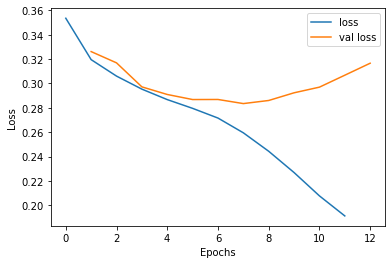

Training time: 13.92 minutes


In [8]:
model = train(
    dataset=(X_train, y_train, X_test, y_test),
    model=model,
    epochs=60,
    validation_freq=1,
    callbacks=[es, lr_schedule, tensorboard_callback],
    verbose=2,
    batch_size=100,
)

In [6]:
model.save(f"../model_saves/final/{model.name}_50.h5")